In [1]:
# coding: utf-8
"""
=============================================================
Gaussian process regression (GPR) with noise-level estimation
高斯过程回归(GPR)与噪声级估计
=============================================================

This example shows the ability of the
:class:`~sklearn.gaussian_process.kernels.WhiteKernel` to estimate the noise
level in the data. Moreover, we show the importance of kernel hyperparameters
initialization.
这个例子展示了
:class:`~sklearn.gaussian_process.kernels。来估计噪音
在数据水平。此外，我们还证明了核超参数的重要性
初始化。
"""

# Authors: Jan Hendrik Metzen <jhm@informatik.uni-bremen.de>
#          Guillaume Lemaitre <guillaume.lemaitre@inria.fr>
# License: BSD 3 clause

'\n=============================================================\nGaussian process regression (GPR) with noise-level estimation\n=============================================================\n\nThis example shows the ability of the\n:class:`~sklearn.gaussian_process.kernels.WhiteKernel` to estimate the noise\nlevel in the data. Moreover, we show the importance of kernel hyperparameters\ninitialization.\n'

In [2]:
# Data generation
# ---------------
#
# We will work in a setting where `X` will contain a single feature. We create a
# function that will generate the target to be predicted. We will add an
# option to add some noise to the generated target.
#数据生成
# ---------------
#我们将在一个设置中工作，其中' X '将包含一个特性。我们创建一个函数，
# 它将生成要预测的目标。我们将添加一个
# 选项添加一些噪声到生成的目标。
import numpy as np


def target_generator(X, add_noise=False):
    target = 0.5 + np.sin(3 * X)
    if add_noise:
        rng = np.random.RandomState(1)
        target += rng.normal(0, 0.3, size=target.shape)
    return target.squeeze()


In [3]:
# Let's have a look to the target generator where we will not add any noise to
# observe the signal that we would like to predict.
# 让我们看看目标生成器，我们不会添加任何噪声来观察我们想要预测的信号。
X = np.linspace(0, 5, num=30).reshape(-1, 1)
y = target_generator(X, add_noise=False)

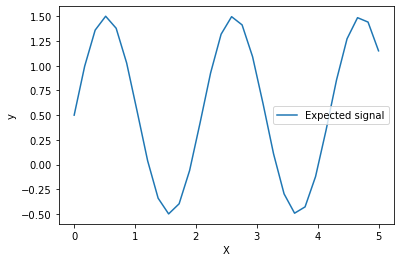

In [4]:
import matplotlib.pyplot as plt

plt.plot(X, y, label="Expected signal")
plt.legend()
plt.xlabel("X")
_ = plt.ylabel("y")

In [5]:
# The target is transforming the input `X` using a sine function. Now, we will
# generate few noisy training samples. To illustrate the noise level, we will
# plot the true signal together with the noisy training samples.
#目标是转换输入' X '使用正弦函数。现在,我们将
#生成很少的噪声训练样本。为了说明噪音水平，我们将
#将真实信号与带有噪声的训练样本绘制在一起了·
rng = np.random.RandomState(0)
X_train = rng.uniform(0, 5, size=20).reshape(-1, 1)
y_train = target_generator(X_train, add_noise=True)

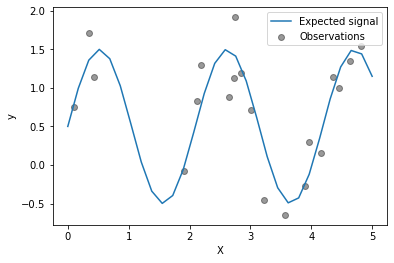

In [6]:
plt.plot(X, y, label="Expected signal")
plt.scatter(
    x=X_train[:, 0],
    y=y_train,
    color="black",
    alpha=0.4,
    label="Observations",
)
plt.legend()
plt.xlabel("X")
_ = plt.ylabel("y")

In [7]:
# Optimisation of kernel hyperparameters in GPR
# ---------------------------------------------
#
# Now, we will create a
# :class:`~sklearn.gaussian_process.GaussianProcessRegressor`
# using an additive kernel adding a
# :class:`~sklearn.gaussian_process.kernels.RBF` and
# :class:`~sklearn.gaussian_process.kernels.WhiteKernel` kernels.
# The :class:`~sklearn.gaussian_process.kernels.WhiteKernel` is a kernel that
# will able to estimate the amount of noise present in the data while the
# :class:`~sklearn.gaussian_process.kernels.RBF` will serve at fitting the
# non-linearity between the data and the target.
#
# However, we will show that the hyperparameter space contains several local
# minima. It will highlights the importance of initial hyperparameter values.
#
# We will create a model using a kernel with a high noise level and a large
# length scale, which will explain all variations in the data by noise.

#现在，我们将创建一个
#:类:“~ sklearn.gaussian_process.GaussianProcessRegressor”
#使用一个附加内核添加一个
#:类:“~ sklearn.gaussian_process.kernels。RBF”和
#:类:“~ sklearn.gaussian_process.kernels。WhiteKernel的内核。
#:类:“~ sklearn.gaussian_process.kernels。WhiteKernel是一个内核
#将能够估计数据中存在的噪声量
#:类:“~ sklearn.gaussian_process.kernels。RBF '将有助于适应
#数据和目标之间的非线性。
#但是，我们将展示超参数空间包含几个局部变量
#最小值。它将强调初始超参数值的重要性。
#我们将创建一个模型使用一个高噪声级和一个大
# length scale，这将通过噪声解释数据中的所有变化。
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

kernel = 1.0 * RBF(length_scale=1e1, length_scale_bounds=(1e-2, 1e3)) + WhiteKernel(
    noise_level=1, noise_level_bounds=(1e-5, 1e1)
)
gpr = GaussianProcessRegressor(kernel=kernel, alpha=0.0)
gpr.fit(X_train, y_train)
y_mean, y_std = gpr.predict(X, return_std=True)

C:\ProgramData\Anaconda3\envs\py39\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


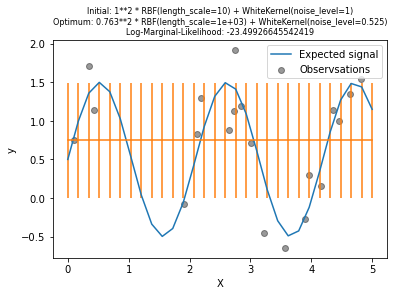

In [8]:
plt.plot(X, y, label="Expected signal")
plt.scatter(x=X_train[:, 0], y=y_train, color="black", alpha=0.4, label="Observsations")
plt.errorbar(X, y_mean, y_std)
plt.legend()
plt.xlabel("X")
plt.ylabel("y")
_ = plt.title(
    f"Initial: {kernel}\nOptimum: {gpr.kernel_}\nLog-Marginal-Likelihood: "
    f"{gpr.log_marginal_likelihood(gpr.kernel_.theta)}",
    fontsize=8,
)

In [9]:
# We see that the optimum kernel found still have a high noise level and
# an even larger length scale. Furthermore, we observe that the
# model does not provide faithful predictions.
#
# Now, we will initialize the
# :class:`~sklearn.gaussian_process.kernels.RBF` with a
# larger `length_scale` and the
# :class:`~sklearn.gaussian_process.kernels.WhiteKernel`
# with a smaller noise level lower bound.
#  我们看到找到的最优内核仍然有一个高噪声水平和
# 一个更大的长度刻度。此外，我们观察到
# 模型没有提供可靠的预测。
# 现在，我们将初始化
#:类:“~ sklearn.gaussian_process.kernels。RBF的用
#更大的' length_scale '和
#:类:“~ sklearn.gaussian_process.kernels.WhiteKernel”
#带有较小的噪音级下限。
kernel = 1.0 * RBF(length_scale=1e-1, length_scale_bounds=(1e-2, 1e3)) + WhiteKernel(
    noise_level=1e-2, noise_level_bounds=(1e-10, 1e1)
)
gpr = GaussianProcessRegressor(kernel=kernel, alpha=0.0)
gpr.fit(X_train, y_train)
y_mean, y_std = gpr.predict(X, return_std=True)

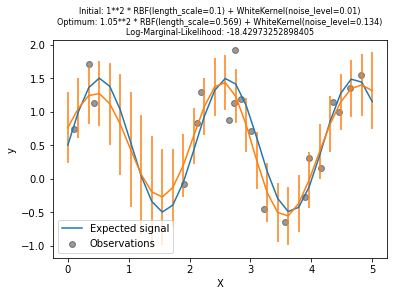

In [10]:
plt.plot(X, y, label="Expected signal")
plt.scatter(x=X_train[:, 0], y=y_train, color="black", alpha=0.4, label="Observations")
plt.errorbar(X, y_mean, y_std)
plt.legend()
plt.xlabel("X")
plt.ylabel("y")
_ = plt.title(
    f"Initial: {kernel}\nOptimum: {gpr.kernel_}\nLog-Marginal-Likelihood: "
    f"{gpr.log_marginal_likelihood(gpr.kernel_.theta)}",
    fontsize=8,
)

In [11]:
# First, we see that the model's predictions are more precise than the
# previous model's: this new model is able to estimate the noise-free
# functional relationship.
#
# Looking at the kernel hyperparameters, we see that the best combination found
# has a smaller noise level and shorter length scale than the first model.
#
# We can inspect the Log-Marginal-Likelihood (LML) of
# :class:`~sklearn.gaussian_process.GaussianProcessRegressor`
# for different hyperparameters to get a sense of the local minima.
#首先,我们看到模型的预测比它更精确 前面的模型:这个新模型能够估计无噪声
#功能关系。
#
#查看内核超参数,我们看到最好的组合被发现
#与第一个模型相比,#的噪声水平更小,长度也更短。
#
#我们可以检查log -边际可能性(LML)
#:class:' ~ sklearn.gaussian_process. gaussianprocessreunk
#使用不同的超参数来了解局部最小值。
from matplotlib.colors import LogNorm

length_scale = np.logspace(-2, 4, num=50)
noise_level = np.logspace(-2, 1, num=50)
length_scale_grid, noise_level_grid = np.meshgrid(length_scale, noise_level)

log_marginal_likelihood = [
    gpr.log_marginal_likelihood(theta=np.log([0.36, scale, noise]))
    for scale, noise in zip(length_scale_grid.ravel(), noise_level_grid.ravel())
]
log_marginal_likelihood = np.reshape(
    log_marginal_likelihood, newshape=noise_level_grid.shape
)

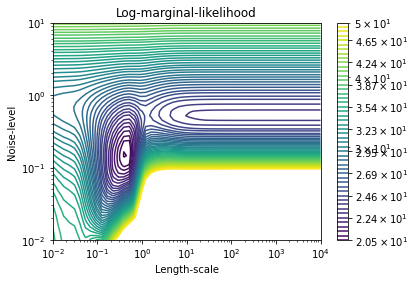

In [12]:
vmin, vmax = (-log_marginal_likelihood).min(), 50
level = np.around(np.logspace(np.log10(vmin), np.log10(vmax), num=50), decimals=1)
plt.contour(
    length_scale_grid,
    noise_level_grid,
    -log_marginal_likelihood,
    levels=level,
    norm=LogNorm(vmin=vmin, vmax=vmax),
)
plt.colorbar()
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Length-scale")
plt.ylabel("Noise-level")
plt.title("Log-marginal-likelihood")
plt.show()

In [13]:
# We see that there are two local minima that correspond to the combination
# of hyperparameters previously found. Depending on the initial values for the
# hyperparameters, the gradient-based optimization might converge whether or
# not to the best model. It is thus important to repeat the optimization
# several times for different initializations.
# 我们看到有两个局部极小值对应于之前发现的超参数的组合。
# 根据超参数初始值的不同，梯度优化算法可能会收敛到最优模型。
# 因此，为不同的初始化重复多次优化是很重要的。